In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kfu-hw-1-classification-2024/test.tsv
/kaggle/input/kfu-hw-1-classification-2024/train.tsv


In [32]:
# !pip install pymorphy2

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk import download
import pymorphy2
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import fasttext

In [8]:
test_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/test.tsv')
train_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/train.tsv')

train_data.head()

,id,tweet,class
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0


**EDA**

In [9]:
train_data['class'].value_counts()

class
0    8683
1     832
Name: count, dtype: int64

In [10]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id       0
tweet    0
class    0
dtype: int64
id       0
tweet    0
dtype: int64


In [11]:
print(train_data['tweet'].duplicated().sum())

1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

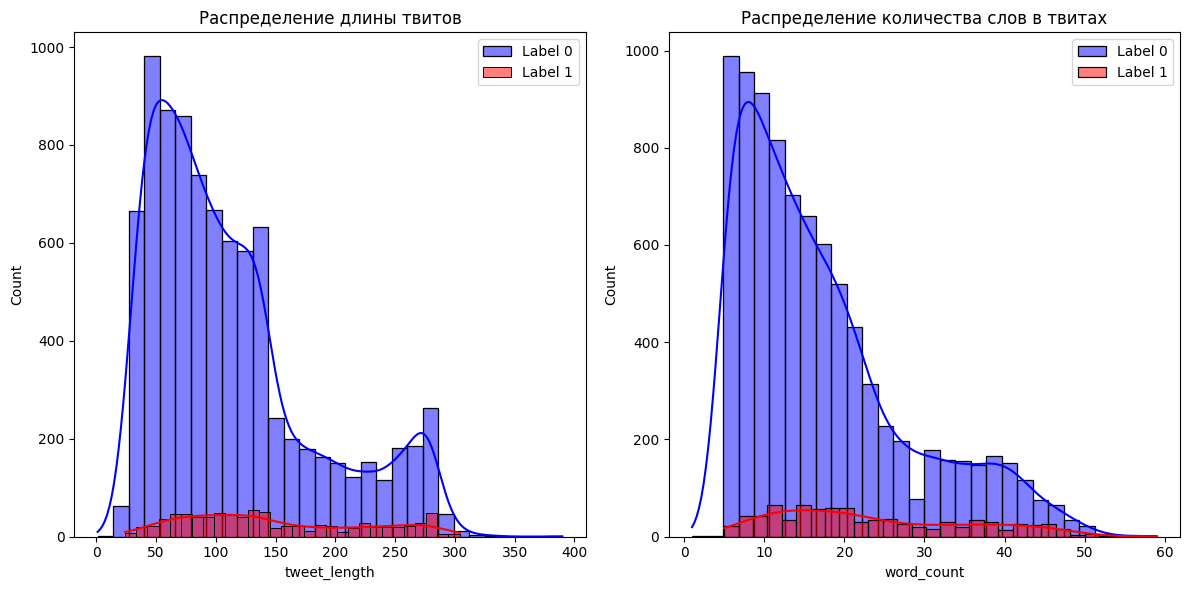

In [12]:
train_data['tweet_length'] = train_data['tweet'].apply(len)
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(x.split()))
test_data['tweet_length'] = test_data['tweet'].apply(len)
test_data['word_count'] = test_data['tweet'].apply(lambda x: len(x.split()))



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data[train_data['class'] == 0]['tweet_length'], kde=True, color='blue', label='Label 0', bins=30)
sns.histplot(train_data[train_data['class'] == 1]['tweet_length'], kde=True, color='red', label='Label 1', bins=30)
plt.title("Распределение длины твитов")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_data[train_data['class'] == 0]['word_count'], kde=True, color='blue', label='Label 0', bins=30)
sns.histplot(train_data[train_data['class'] == 1]['word_count'], kde=True, color='red', label='Label 1', bins=30)
plt.title("Распределение количества слов в твитах")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['class'], random_state=42)

**Feature Engineering**

In [16]:
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 16.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [17]:
# Text normalization

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

train_data['cleaned_tweet'] = train_data['tweet'].apply(preprocess_text)
test_data['cleaned_tweet'] = test_data['tweet'].apply(preprocess_text)
val_data['cleaned_tweet'] = val_data['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
nlp = spacy.load('ru_core_news_sm')

def pos_analysis(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


train_data['pos_tags'] = train_data['cleaned_tweet'].apply(pos_analysis)
test_data['pos_tags'] = test_data['cleaned_tweet'].apply(pos_analysis)
val_data['pos_tags'] = val_data['cleaned_tweet'].apply(pos_analysis)

train_data.head(5)

,id,tweet,class,tweet_length,word_count,cleaned_tweet,pos_tags
6320,1076514946660343808,Бля спасибо сибутрамину и отсутствию денег на ...,0,69,12,бля спасибо сибутрамин отсутствие деньга обед ...,"[NOUN, NOUN, PROPN, NOUN, PROPN, NOUN, VERB, N..."
184,1068652794314412033,"Ребятки, мне реально страшно. Похоже я попал н...",1,227,39,ребятки реально страшно похоже попасть новый п...,"[NOUN, ADV, ADJ, ADJ, VERB, ADJ, NOUN, NOUN, P..."
9007,961197666083459072,А эти самые норвежцы первые в мире допингомены...,0,82,11,самый норвежец первый мир допингомена допинг с...,"[ADJ, NOUN, ADJ, NOUN, PROPN, PROPN, PROPN, PR..."
9127,985690534319665152,"Есть перестал, прозак криво вставлял",0,36,5,перестать прозак кривой вставлять,"[VERB, NOUN, ADJ, VERB]"
2668,1088712684856578048,ты вызываешь жалость можешь скушать ксанакс и ...,0,60,10,вызывать жалость мочь скушать ксанакс забыть о,"[VERB, NOUN, ADV, VERB, PROPN, VERB, ADP]"


In [19]:
# Sentiment analysis

classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

def analyze_sentiment(text):
    result = classifier(text)[0]  
    return result['label'], result['score']  

train_data[['sentiment_label', 'sentiment_score']] = train_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

test_data[['sentiment_label', 'sentiment_score']] = test_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

val_data[['sentiment_label', 'sentiment_score']] = val_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)



# print(train_data)

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Топ-20 слов: [('это', 710), ('ксанакс', 690), ('прозак', 477), ('флуоксетин', 379), ('таблетка', 289), ('пить', 268), ('день', 255), ('флуоксетина', 226), ('который', 218), ('сальбутамол', 214), ('лоперамид', 211), ('препарат', 211), ('паксила', 209), ('тамифить', 206), ('такой', 202), ('ещё', 196), ('год', 188), ('просто', 184), ('хотеть', 180), ('очень', 175)]


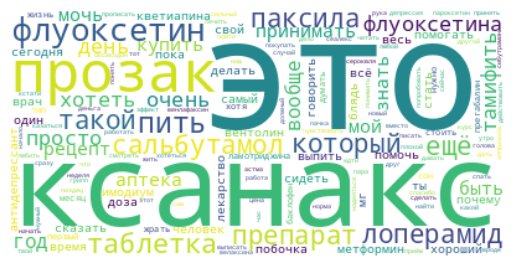

In [20]:
def get_top_n_words(corpus, n=None):
    words = ' '.join(corpus).split()
    return Counter(words).most_common(n)

all_tweets = train_data['cleaned_tweet']
top_words = get_top_n_words(all_tweets, n=20)
print("Топ-20 слов:", top_words)

wordcloud = WordCloud(background_color='white').generate(' '.join(all_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
train_data.head()

,id,tweet,class,tweet_length,word_count,cleaned_tweet,pos_tags,sentiment_label,sentiment_score
6320,1076514946660343808,Бля спасибо сибутрамину и отсутствию денег на ...,0,69,12,бля спасибо сибутрамин отсутствие деньга обед ...,"[NOUN, NOUN, PROPN, NOUN, PROPN, NOUN, VERB, N...",POSITIVE,0.853001
184,1068652794314412033,"Ребятки, мне реально страшно. Похоже я попал н...",1,227,39,ребятки реально страшно похоже попасть новый п...,"[NOUN, ADV, ADJ, ADJ, VERB, ADJ, NOUN, NOUN, P...",NEGATIVE,0.751460
9007,961197666083459072,А эти самые норвежцы первые в мире допингомены...,0,82,11,самый норвежец первый мир допингомена допинг с...,"[ADJ, NOUN, ADJ, NOUN, PROPN, PROPN, PROPN, PR...",NEUTRAL,0.817690
9127,985690534319665152,"Есть перестал, прозак криво вставлял",0,36,5,перестать прозак кривой вставлять,"[VERB, NOUN, ADJ, VERB]",NEUTRAL,0.826482
2668,1088712684856578048,ты вызываешь жалость можешь скушать ксанакс и ...,0,60,10,вызывать жалость мочь скушать ксанакс забыть о,"[VERB, NOUN, ADV, VERB, PROPN, VERB, ADP]",NEUTRAL,0.481951


In [ ]:
train_data['sentiment_label'].value_counts()

In [ ]:
print(train_data.describe())
print(test_data.describe())

In [ ]:
#Vectorization
#Class Disbalance
#Model learning


In [ ]:
train_data.head(3)

In [26]:
# without post_tags

vectorizer = TfidfVectorizer(max_features=5000)
X_train_text = vectorizer.fit_transform(train_data['cleaned_tweet'])
X_val_text = vectorizer.transform(val_data['cleaned_tweet'])

additional_features_train = train_data[['tweet_length', 'word_count', 'sentiment_score']].values
additional_features_val = val_data[['tweet_length', 'word_count', 'sentiment_score']].values

X_train = np.hstack([X_train_text.toarray(), additional_features_train])
X_val = np.hstack([X_val_text.toarray(), additional_features_val])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, train_data['class'])

model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [28]:
predictions = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:, 1]

# Метрики
print("Classification Report:")
print(classification_report(val_data['class'], predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], predictions))
print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1111
           1       0.45      0.09      0.16       107

    accuracy                           0.91      1218
   macro avg       0.69      0.54      0.55      1218
weighted avg       0.88      0.91      0.88      1218

Confusion Matrix:
[[1099   12]
 [  97   10]]
ROC-AUC Score: 0.7689124052592176


In [30]:
model = XGBClassifier(random_state=42, scale_pos_weight=len(train_data[train_data['class'] == 0]) / len(train_data[train_data['class'] == 1]))
model.fit(X_train, train_data['class'])


predictions = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:, 1]

# Метрики
print("Classification Report:")
print(classification_report(val_data['class'], predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], predictions))
print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1111
           1       0.30      0.37      0.33       107

    accuracy                           0.87      1218
   macro avg       0.62      0.64      0.63      1218
weighted avg       0.88      0.87      0.87      1218

Confusion Matrix:
[[1017   94]
 [  67   40]]
ROC-AUC Score: 0.720555700429856


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
!gzip -d cc.ru.300.bin.gz

--2025-01-22 11:59:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.158.20.43, 108.158.20.111, 108.158.20.21, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.158.20.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz    100%[===================>]   4.19G  26.7MB/s    in 3m 5s   

2025-01-22 12:02:46 (23.2 MB/s) - ‘cc.ru.300.bin.gz’ saved [4496459151/4496459151]



In [37]:
# Try another vectorization


ft = fasttext.load_model('cc.ru.300.bin')

# Функция для получения эмбеддингов для каждого твита
def get_fasttext_embeddings(texts):
    return [ft.get_sentence_vector(text) for text in texts]

X_train_text_fasttext = np.array(get_fasttext_embeddings(train_data['cleaned_tweet']))
X_val_text_fasttext = np.array(get_fasttext_embeddings(val_data['cleaned_tweet']))

additional_features_train = train_data[['tweet_length', 'word_count', 'sentiment_score']].values
additional_features_val = val_data[['tweet_length', 'word_count', 'sentiment_score']].values

X_train = np.hstack([X_train_text_fasttext, additional_features_train])
X_val = np.hstack([X_val_text_fasttext, additional_features_val])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, train_data['class'])

model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)


predictions = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:, 1]

# Метрики
print("Classification Report:")
print(classification_report(val_data['class'], predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], predictions))
print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1111
           1       0.38      0.25      0.30       107

    accuracy                           0.90      1218
   macro avg       0.66      0.61      0.62      1218
weighted avg       0.88      0.90      0.89      1218

Confusion Matrix:
[[1067   44]
 [  80   27]]
ROC-AUC Score: 0.808154647240425


In [38]:
model = XGBClassifier(random_state=42, scale_pos_weight=len(train_data[train_data['class'] == 0]) / len(train_data[train_data['class'] == 1]))
model.fit(X_train, train_data['class'])


predictions = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:, 1]

# Метрики
print("Classification Report:")
print(classification_report(val_data['class'], predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], predictions))
print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1111
           1       0.55      0.22      0.32       107

    accuracy                           0.92      1218
   macro avg       0.74      0.60      0.64      1218
weighted avg       0.90      0.92      0.90      1218

Confusion Matrix:
[[1091   20]
 [  83   24]]
ROC-AUC Score: 0.7912548264172211


In [50]:
from sklearn.model_selection import cross_val_score, GridSearchCV

rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_resampled, y_train_resampled)

best_rf = grid_rf.best_estimator_
best_rf

Fitting 3 folds for each of 36 candidates, totalling 108 fits


RandomForestClassifier(n_estimators=150, random_state=42)

In [45]:
xgb = XGBClassifier(random_state=42, eval_metric="logloss")

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_xgb.fit(X_train, train_data['class'])

best_xgb = grid_xgb.best_estimator_
best_xgb

Fitting 3 folds for each of 18 candidates, totalling 54 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [52]:
y_pred_rf = best_rf.predict(X_val)
y_pred_xgb = best_xgb.predict(X_val)
pred_proba_rf = best_rf.predict_proba(X_val)[:, 1]
pred_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]

print("Classification Report Random Forest:")
print(classification_report(val_data['class'], y_pred_rf))
print("Classification Report XgBoost:")
print(classification_report(val_data['class'], y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], y_pred_rf))
print(confusion_matrix(val_data['class'], y_pred_xgb))

print("ROC-AUC Score for Random Forest:", roc_auc_score(val_data['class'], pred_proba_rf))
print("ROC-AUC Score for XgBoost:", roc_auc_score(val_data['class'], pred_proba_xgb))


Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1111
           1       0.40      0.25      0.31       107

    accuracy                           0.90      1218
   macro avg       0.66      0.61      0.63      1218
weighted avg       0.88      0.90      0.89      1218

Classification Report XgBoost:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1111
           1       0.52      0.14      0.22       107

    accuracy                           0.91      1218
   macro avg       0.72      0.56      0.59      1218
weighted avg       0.89      0.91      0.89      1218

Confusion Matrix:
[[1070   41]
 [  80   27]]
[[1097   14]
 [  92   15]]
ROC-AUC Score: 0.8227495646760938
ROC-AUC Score: 0.8077761047132751


In [58]:
# Just LTSM without added features

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Подготовка данных для LSTM
X_train_text = X_train_resampled[:, :-3]  # Извлекаем только эмбеддинги
X_val_text = X_val[:, :-3]  # То же для валидации

# Паддинг данных (если необходимо привести к одинаковой длине)
max_sequence_length = 300  # Длина последовательности, можно регулировать
X_train_pad = pad_sequences(X_train_text, padding='post', maxlen=max_sequence_length)
X_val_pad = pad_sequences(X_val_text, padding='post', maxlen=max_sequence_length)

# Создание модели LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(max_sequence_length, 1), return_sequences=True))  # input_shape корректируем
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))  # Для бинарной классификации

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train_pad, y_train_resampled, epochs=5, batch_size=64, validation_data=(X_val_pad, val_data['class']))

y_pred = model.predict(X_val_final)

# Преобразуем вероятности в метки (0 или 1)
y_pred_labels = (y_pred > 0.5).astype(int)


print(confusion_matrix(val_data['class'], y_pred_labels))
print(classification_report(val_data['class'], y_pred_labels))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 73s 498ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.9122 - val_loss: 0.6919
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 504ms/step - accuracy: 0.5051 - loss: 0.6932 - val_accuracy: 0.0878 - val_loss: 0.7001
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 499ms/step - accuracy: 0.4969 - loss: 0.6933 - val_accuracy: 0.9122 - val_loss: 0.6931
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 502ms/step - accuracy: 0.5077 - loss: 0.6932 - val_accuracy: 0.9122 - val_loss: 0.6908
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.4990 - loss: 0.6932 - val_accuracy: 0.9122 - val_loss: 0.6853
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step
[[1111    0]
 [ 107    0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1111
           1       0.00      0.00      0.00       107

    accuracy                           0.91      1218
   macro avg       0.46      0.50      0.48      1218
weighted a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
